# Garbage Classification - A task from the Gemeente

(Last updated: Jan 29, 2024)[^credit]

[^credit]: Credit: this teaching material is created by Bryan Fleming under the supervision of [Yen-Chia Hsu](https://github.com/yenchiah).

Here is an online version of [this notebook in Google Colab](https://colab.research.google.com/drive/10kYsTaWb7DA-qvroa73PaLdbSpAfeckD?usp=sharing). This online version is just for browsing. To work on this notebook, you need to copy a new one to your own Google Colab.

In [1]:
# Importing Libraries

import math
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
from torchvision.utils import make_grid
from IPython.display import Image
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

**First, you need to enable GPUs for the notebook in Google Colab:**

- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")          # use CUDA device
elif torch.backends.mps.is_available:
    device = torch.device("mps")          # use MPS device
else:
    device = torch.device("cpu")           # use CPU device
device

device(type='mps')

Make sure that the ouput from the above cell is `device(type='cuda')`. If you see `device(type='cpu')`, it means that you did not enable GPU usage on Google Colab. Go to [this page](https://web.eecs.umich.edu/~justincj/teaching/eecs442/WI2021/colab.html) and check the "Use GPU as an accelerator" part for details. Please be patient for this tutorial and the assignment, as training neural networks for Computer Vision tasks typically takes a lot of time.

## Scenario

As members of the data science course, you have been tasked with a challenging and meaningful project: you will help give feedback on machine learning algorithms, designed for classifying types of garbage for the Gemeente Amsterdam. This project offers a unique opportunity to apply your data science skills to a real-world problem, making a positive impact on your local community.

Waste management is a critical issue that affects us all. As our population grows (and we know how much the population of Amsterdam is growing) and consumption increases, the amount of waste we generate also increases. One way to manage this waste is to classify it according to its type, making it easier to handle and recycle. However, manually classifying waste is time-consuming and prone to error, which is where machine learning can help.

Machine learning algorithms can be trained to recognize patterns in data and make accurate predictions based on those patterns. In the case of garbage classification, machine learning can help to identify the type of garbage based on its physical properties, such as size, shape, and color. By automating this process, we can improve the efficiency and accuracy of waste management and recycling.

As you work on this project, you will have the opportunity to apply your knowledge of data science, statistics, and machine learning to a real-world problem. You will learn how to clean, preprocess, and explore data, how to train machine learning algorithms, and how to evaluate and optimize the performance of your models.

This project will challenge you to think creatively, to collaborate with your peers, and to apply your skills to a problem that has real-world implications. We encourage you to take ownership of your work, to explore different methods and algorithms, and to document your process and results thoroughly.

In the end, your efforts will contribute to improving the waste management and recycling practices of the Gemeente Amsterdam, making a positive impact on the environment and the community. We wish you the best of luck in this exciting and meaningful project, and we look forward to seeing the results of your hard work.

The Gemeente needs critical analysis and feedback on their draft algorithms, so they can make an effective classifcation system in the future - to replace most of the current manpower and update the convoluted systems currently in place.

## Load Datasets

**These aren't mock-up datasets, they're real world data!**

To work with the [garbage classification dataset](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification), we need to download the data. We have prepared a [GitHub repository](https://github.com/MultiX-Amsterdam/image-data-module/tree/main/garbage-classification-dataset) with the dataset for you.

The following code checks if you are using Google Colab or on a local machine with GPU. If you clone the repository to your local machine, there is no need to download the dataset. However, if you are on Google Colab, the code cell below will clone the dataset to the Google Colab's file disk.

In [3]:
# This is the relative path for data if you clone the repository to a local machine
data_dir  = 'garbage-classification-dataset/garbage-classification-images'
try:
  classes = os.listdir(data_dir)
  print(classes)
except:
  # This means that we are not on a local machine, so we need to clone the dataset
  !git clone https://github.com/MultiX-Amsterdam/image-data-module
  # Below is the path of the data on the Google Colab disk
  data_dir  = '/content/image-data-module/garbage-classification-dataset/garbage-classification-images'
  classes = os.listdir(data_dir)
  print(classes)

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


### Transform Data

To input the data into a machine learning algorithm, we need to transform the dataset into a normalized tensor. We can do this using PyTorch's built-in transforms module.

In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.CenterCrop(224), transforms.ToTensor()])

In this example, we're resizing the images to 256x256 pixels and cropping them to 224x224 pixels from the center. We then convert the images to tensors using transforms.ToTensor().


In [5]:
dataset = ImageFolder(data_dir, transform = transformations)

We then apply these transforms to the dataset using the datasets.ImageFolder class, which automatically applies the transforms to the images in the dataset:

### Visualize Data

As we work on building our machine learning model for image classification, it's important to understand the data that we're working with. One way to gain a better understanding of the data is by visualizing it. By looking at the images in the dataset, we can get a sense of what features and patterns are present in the images, which can inform our choice of model architecture and training strategy.

To visualize the data, we can use a Python library like matplotlib to display sample images from the dataset along with their corresponding labels. This can help us get a sense of what types of images are present in the dataset, and how they are distributed across different classes.

To make this process easier, we can define a function that takes in a dataset object and displays a grid of images along with their corresponding labels. This function can be called at any point during our analysis to visualize the data and gain a better understanding of the images we're working with.

As we continue to work on building our machine learning model, we'll be using this function to visualize the data and its classes, and gain insights that will help us build a better model.

In [6]:
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


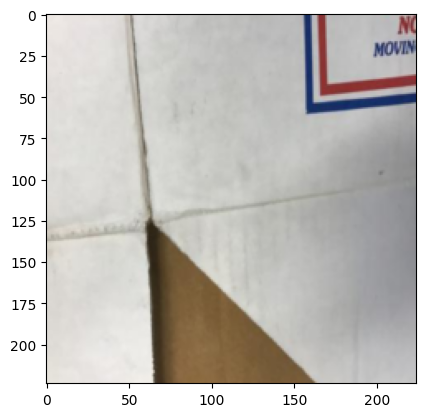

In [7]:
img, label = dataset[2]
show_sample(img, label)

### Split Data

In order to train our machine learning model, we need to split our data into training, validation, and test sets. We need to set a seed for the random number generator. This ensures that our data is split in a consistent way each time we run our code, which is important for reproducibility. In the code snippet below, we set the random seed to 23 and the manual seed to ensure that the split is consistent.

In [8]:
# Setting a seed for the random split of data:

random_seed = 23
torch.manual_seed(random_seed)

Once the seed is set, we can split our dataset into training, validation, and test sets. In the code snippet below, we use PyTorch's random_split function to split our dataset into three sets: 1593 images for training, 176 images for validation, and 758 images for testing.

In [9]:
# Splitting the data:

train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

### Build a Dataloader

Finally, we can load our dataset into PyTorch data loaders, which will allow us to efficiently feed the data into our machine learning model. In the code snippet below, we define data loaders for our training and validation sets, with a batch size of 32 for the training data and a batch size of 64 for the validation data. We also set the `shuffle`, `num_workers`, and `pin_memory` parameters to optimize the data loading process.

Keep in mind that the batch size is a hyperparameter that you can tune. However, setting the batch size to a large number may not be a good idea if your GPU and computer only have a small computer memory. Using a larger batch size consumes more computer and GPU memory.

In [10]:
# Loading the data

batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

### Check the Dataloader

As we mentioned earlier, visualizing our data is an important step in the machine learning process. By looking at sample images from our dataset, we can gain insights into the structure of the data and identify any issues with preprocessing or data loading.

To make the visualization process easier, we can define a function called `show_batch` that takes in a PyTorch data loader and displays a grid of images from the batch along with their corresponding labels. This can help us identify patterns and features in the images, and ensure that our data is being loaded and preprocessed correctly.

In the code snippet below, we define the `show_batch` function. This function takes in a data loader object and displays a grid of images from the batch along with their corresponding labels. We use the `make_grid` function to create a grid of images from the batch, with 16 images per row. The permute function is used to change the order of the dimensions of the tensor to match the expected input format for imshow.



In [11]:
# As before, we have a simple tool for visualization

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

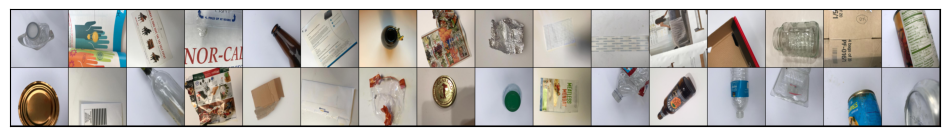

In [12]:
show_batch(train_dl)

Now that we've had a chance to visualize our data and ensure that our data loading and preprocessing is working correctly, it's time to move on to the main part of our machine learning implementation: network creation.

Our goal is to build a neural network that can accurately classify images into different categories. To do this, we'll need to create a network architecture that is appropriate for the task at hand. This can involve a variety of decisions, such as the number of layers in the network, the size of the filters used in convolutional layers, and the activation functions used throughout the network.

Building a neural network can be a complex process, but fortunately, we have powerful tools and libraries available to simplify the task. We'll be using PyTorch, a popular deep learning framework, to build our network.

## Build the Pipeline

In order to train and evaluate our neural network, we'll need to be able to load our pre-processed data into our model and assess its performance on our validation and test sets. To do this, we have two critical functions at our disposal: data loading and model evaluation.

Data loading involves reading our pre-processed data from disk and converting it into a format that can be input into our neural network. This can involve operations such as loading images, transforming them into tensors, and creating batches for efficient processing. By properly loading our data, we can ensure that our network is able to process the data effectively and accurately.

Model evaluation, on the other hand, involves assessing the performance of our neural network on our validation and test sets. We'll be using a variety of metrics, such as accuracy and F1 score, to evaluate the performance of our model. This is critical for determining how well our network is able to classify images and whether it is ready for deployment.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ImageClassificationBase(nn.Module):
    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.accuracy(out, labels)      # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

After completing the initial data wrangling and evaluation, we're now ready to move onto the exciting part of our machine learning implementation: tweaking and evaluating our neural networks.

We have several different neural networks that we'll be working with, all based on the ResNet architecture, but with key differences. Each network has been created and initialized with specific goals and objectives in mind. While some of the methods used may be exaggerated for the purposes of demonstrating key concepts, it's important to keep in mind that each of these methods plays a critical role in the overall performance of our network.

During our evaluation process, we'll be focusing primarily on accuracy as our key metric for assessing the performance of our neural networks. By analyzing the accuracy of our networks, we can determine how well they are able to classify images and identify areas where they may be struggling. While there are other metrics, such as F1 score and confusion matrices, that can also provide valuable insights into the performance of our networks, we'll be primarily focusing on accuracy to streamline our evaluation process.

Throughout this process, you'll be asked a series of questions about our neural networks and their performance. By fully engaging with this process, you'll gain a deeper understanding of the key concepts and techniques involved in building and evaluating machine learning models. So let's dive in and start building our networks!

As you work through our implementation, you may (hopefully) notice that some of the features of our neural networks are exaggerated or skewed for specific goals. For example, we may use extreme weight initialization techniques to emphasize the importance of proper weight initialization, or to allow the network to display certain traits. While these features may not always be representative of real-world scenarios, they can be helpful in highlighting key concepts and techniques that are critical for success in machine learning. By understanding the reasoning behind these exaggerated features, you'll be better equipped to apply these techniques in real-world situations and achieve better performance from your neural networks.

Below you'll see the Network Architecture for ResNet - It's interesting to see the complex detail behind recognizing features, and determining their importance for a classification problem, we will be using tweaked versions of this CNN for our CNN's. The ResNet architecture is explained in the following paper:
- [He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).](https://arxiv.org/pdf/1512.03385.pdf)

![](https://github.com/MultiX-Amsterdam/image-data-module/blob/main/images/resnet50.png?raw=true)

Image source -- https://doi.org/10.3390/s20020447

Notice that in this tutorial, to save computational time, we are going to use the ResNet18 structure, which is a smaller version of the ResNet.

### Task 3: Optimizer

Now let us create a basic ResNet for this task.

In the code below, we first use `get_default_device()` to get the default device (CPU or GPU) for training. We then initialize our `ResNetGaussianWeight` model and move it to the device using `to_device()`. Next, we move our training and validation data loaders to the device using `DeviceDataLoader()`. We set the number of epochs using `num_epochs`, and select the optimizer and learning rate using `opt_func` and `lr`, respectively. Finally, we train the model using the `fit()` function and store the training history in history.

It is worth noting that this is the only time we will be breaking down this specific block of code in such detail. From here on out, we will assume a basic understanding of the concepts and functions used in this code and focus on the unique features and characteristics of each neural network we explore.

In [14]:
class ResNetGaussianWeight(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

        # Gaussian random weight initialization for all the weights
        for module in self.network.modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                init.normal_(module.weight, mean=0, std=0.0001)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, xb):
        return self.network(xb)


device = get_default_device() # get the default device for training
model = ResNetGaussianWeight() # initialize the ResNet model
model = to_device(model, device) # move the model to the device (CPU or GPU)
train_dl = DeviceDataLoader(train_dl, device) # move the training data loader to the device
val_dl = DeviceDataLoader(val_dl, device) # move the validation data loader to the device

num_epochs = 10 # set the number of epochs
opt_func = torch.optim.SGD # set the optimizer
lr = 1e-4 # set the learning rate

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func) # train the model and store the training history

/Users/mon/teaching/DS/modules/image-data-module/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mon/teaching/DS/modules/image-data-module/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10ef14550>
Traceback (most recent call last):
  File "/Users/mon/teaching/DS/modules/image-data-module/.conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/mon/teaching/DS/modules/image-data-module/.conda/lib/python3.9/site-packages/torch/utils/d

KeyboardInterrupt: 

The code above uses the [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (Stochastic Gradient Descent) optimizer. Now let us change the optimizer to [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), which is explained in the following paper:
- [Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.](https://arxiv.org/pdf/1412.6980.pdf)

In [15]:
device = get_default_device() # get the default device for training
model = ResNetGaussianWeight() # initialize the ResNet model
model = to_device(model, device) # move the model to the device (CPU or GPU)
train_dl = DeviceDataLoader(train_dl, device) # move the training data loader to the device
val_dl = DeviceDataLoader(val_dl, device) # move the validation data loader to the device

num_epochs = 10 # set the number of epochs
opt_func = torch.optim.Adam # set the optimizer
lr = 1e-4 # set the learning rate

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func) # train the model and store the training history

Epoch 1: train_loss: 1.6952, val_loss: 1.7517, val_acc: 0.1788
Epoch 2: train_loss: 1.6152, val_loss: 1.9047, val_acc: 0.3108
Epoch 3: train_loss: 1.4956, val_loss: 1.9757, val_acc: 0.3576
Epoch 4: train_loss: 1.4486, val_loss: 3.1670, val_acc: 0.2882
Epoch 5: train_loss: 1.4216, val_loss: 1.9545, val_acc: 0.3281
Epoch 6: train_loss: 1.3946, val_loss: 1.4120, val_acc: 0.4705
Epoch 7: train_loss: 1.3600, val_loss: 1.3967, val_acc: 0.4774
Epoch 8: train_loss: 1.3594, val_loss: 2.1816, val_acc: 0.3646
Epoch 9: train_loss: 1.3598, val_loss: 1.4307, val_acc: 0.4514
Epoch 10: train_loss: 1.3085, val_loss: 1.4177, val_acc: 0.4062


#### Assignment 3

In this task, we used two different optimizers while keeping all other settings and hyperparameters the same. What do you observe for the evaluation results? What are the differences?

YOUR ANSWER HERE

### Task 4: Learning Rate

Continue Task 3, now let us keep using the SGD optimizer while lowering the learning rate.

In [19]:
device = get_default_device() # get the default device for training
model = ResNetGaussianWeight() # initialize the ResNet model
model = to_device(model, device) # move the model to the device (CPU or GPU)
train_dl = DeviceDataLoader(train_dl, device) # move the training data loader to the device
val_dl = DeviceDataLoader(val_dl, device) # move the validation data loader to the device

num_epochs = 10 # set the number of epochs
opt_func = torch.optim.SGD # set the optimizer
lr = 1e-8 # set the learning rate

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func) # train the model and store the training history

/Users/mon/teaching/DS/modules/image-data-module/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mon/teaching/DS/modules/image-data-module/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: train_loss: 1.7918, val_loss: 1.7918, val_acc: 0.1788
Epoch 2: train_loss: 1.7918, val_loss: 1.7918, val_acc: 0.1788
Epoch 3: train_loss: 1.7918, val_loss: 1.7918, val_acc: 0.2378
Epoch 4: train_loss: 1.7918, val_loss: 1.7918, val_acc: 0.2378
Epoch 5: train_loss: 1.7918, val_loss: 1.7918, val_acc: 0.2326
Epoch 6: train_loss: 1.7918, val_loss: 1.7918, val_acc: 0.2431


KeyboardInterrupt: 

Now let us increase the learning rate to a large number and still keep using the SGD optimizer.

In [ ]:
device = get_default_device() # get the default device for training
model = ResNetGaussianWeight() # initialize the ResNet model
model = to_device(model, device) # move the model to the device (CPU or GPU)
train_dl = DeviceDataLoader(train_dl, device) # move the training data loader to the device
val_dl = DeviceDataLoader(val_dl, device) # move the validation data loader to the device

num_epochs = 10 # set the number of epochs
opt_func = torch.optim.SGD # set the optimizer
lr = 12 # set the learning rate

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func) # train the model and store the training history

Epoch 1: train_loss: 63.9864, val_loss: 4.8498, val_acc: 0.1788
Epoch 2: train_loss: 2.6399, val_loss: 3.1096, val_acc: 0.1788
Epoch 3: train_loss: 2.3897, val_loss: 4.2122, val_acc: 0.1441
Epoch 4: train_loss: 2.5924, val_loss: 6.6786, val_acc: 0.1441
Epoch 5: train_loss: 2.7379, val_loss: 3.1218, val_acc: 0.1441
Epoch 6: train_loss: 3.4827, val_loss: 4.5292, val_acc: 0.1441
Epoch 7: train_loss: 2.8348, val_loss: 6.5850, val_acc: 0.1441
Epoch 8: train_loss: 2.5733, val_loss: 4.2799, val_acc: 0.1441
Epoch 9: train_loss: 2.3948, val_loss: 9.4603, val_acc: 0.2708
Epoch 10: train_loss: 2.5807, val_loss: 4.2524, val_acc: 0.1441


#### Assignment 4

In this task, we used two different learning rates while keeping all other settings and hyperparameters the same. What do you observe for the evaluation results? What are the differences of these results when compared to the SGD optimizer version in Task 3?

YOUR ANSWER HERE

### Task 5: Weight Initiation

Next, let us initialize all the model weights to zero. We still keep using the SGD optimizer and keep the learning rate the same as the one used in Task 3.

In [ ]:
class ResNetZeroWeight(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

        # Zero weight initialization for all the weights
        for module in self.network.modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                init.zeros_(module.weight)
                if module.bias is not None:
                      init.zeros_(module.bias)

    def forward(self, xb):
        return self.network(xb)


device = get_default_device() # get the default device for training
model = ResNetZeroWeight() # initialize the ResNet model
model = to_device(model, device) # move the model to the device (CPU or GPU)
train_dl = DeviceDataLoader(train_dl, device) # move the training data loader to the device
val_dl = DeviceDataLoader(val_dl, device) # move the validation data loader to the device

num_epochs = 10 # set the number of epochs
opt_func = torch.optim.SGD # set the optimizer
lr = 1e-4 # set the learning rate

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func) # train the model and store the training history

Epoch 1: train_loss: 1.7917, val_loss: 1.7917, val_acc: 0.2708
Epoch 2: train_loss: 1.7916, val_loss: 1.7916, val_acc: 0.2708
Epoch 3: train_loss: 1.7915, val_loss: 1.7915, val_acc: 0.2708
Epoch 4: train_loss: 1.7914, val_loss: 1.7914, val_acc: 0.2708
Epoch 5: train_loss: 1.7914, val_loss: 1.7913, val_acc: 0.2708
Epoch 6: train_loss: 1.7913, val_loss: 1.7912, val_acc: 0.2708
Epoch 7: train_loss: 1.7912, val_loss: 1.7911, val_acc: 0.2708
Epoch 8: train_loss: 1.7911, val_loss: 1.7910, val_acc: 0.2708
Epoch 9: train_loss: 1.7910, val_loss: 1.7909, val_acc: 0.2708
Epoch 10: train_loss: 1.7909, val_loss: 1.7908, val_acc: 0.2708


Besides the Gaussian weight initialization that we used in the previous task, we can also use uniform weight initialization. The method is documented in the following paper and has been used widely.
- [He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).](https://arxiv.org/pdf/1502.01852.pdf)

In the following code, we change only the weight initialization. We still keep using the SGD optimizer and keep the learning rate the same as the one used in Task 3.


In [14]:
class ResNetUniformWeight(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

        # Kaiming initialization for all the weights
        for module in self.network.modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    fan_in, _ = init._calculate_fan_in_and_fan_out(module.weight)
                    bound = 1 / math.sqrt(fan_in)
                    init.uniform_(module.bias, -bound, bound)

    def forward(self, xb):
        return self.network(xb)


device = get_default_device() # get the default device for training
model = ResNetUniformWeight() # initialize the ResNet model
model = to_device(model, device) # move the model to the device (CPU or GPU)
train_dl = DeviceDataLoader(train_dl, device) # move the training data loader to the device
val_dl = DeviceDataLoader(val_dl, device) # move the validation data loader to the device

num_epochs = 10 # set the number of epochs
opt_func = torch.optim.SGD # set the optimizer
lr = 1e-4 # set the learning rate

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func) # train the model and store the training history

/Users/mon/teaching/DS/modules/image-data-module/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mon/teaching/DS/modules/image-data-module/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: train_loss: 2.6756, val_loss: 2.5257, val_acc: 0.1319
Epoch 2: train_loss: 2.3231, val_loss: 2.2605, val_acc: 0.1424
Epoch 3: train_loss: 2.0575, val_loss: 1.9824, val_acc: 0.1667
Epoch 4: train_loss: 1.8794, val_loss: 1.8207, val_acc: 0.1597
Epoch 5: train_loss: 1.7616, val_loss: 1.7120, val_acc: 0.2569
Epoch 6: train_loss: 1.6851, val_loss: 1.6425, val_acc: 0.3681
Epoch 7: train_loss: 1.6362, val_loss: 1.5852, val_acc: 0.4410
Epoch 8: train_loss: 1.5971, val_loss: 1.5502, val_acc: 0.4670
Epoch 9: train_loss: 1.5643, val_loss: 1.5185, val_acc: 0.4566
Epoch 10: train_loss: 1.5467, val_loss: 1.4893, val_acc: 0.4653


#### Assignment 5

This task shows you two other different ways of initializing the model weights (i.e., the model parameters). What do you observe for the evaluation results? What are the differences of these results when compared to the SGD optimizer version in Task 3?

YOUR ANSWER HERE

### Task 6: Model explanations

In this task we will perform a cualitative analysis of the model performance by visualizing which images are predicted as each class and their GradCAMs. This can help us understand where the model is failing.

#### Assignment 6
Display GradCAMs for the last model. You can use the function `display_grad_cam` provided in the tutorial. What do you observe in the gradCAMs for the different classes? What does the model pay attention to for each class? Can you spot any patterns in the errors made by the model?
- Hint: For this task, it would be convenient to divide the test images by the class assigned by the model, so you can display one grid per predicted class.
- Hint: adding the arguments `aug_smooth=True, eigen_smooth=True` to the `grad_cam` call will make the maps look better.

In [15]:
def scale_to_01(arr):
    """
    Scales an array so all its values lie in the interval [0, 1].

    Parameters
    ----------
    arr : numpy.array
        The original array.

    Returns
    -------
    numpy.array
        The sclaed array.
    """
    min_val = arr.min()
    max_val = arr.max()
    scaled_array = (arr - min_val) / (max_val - min_val)
    return scaled_array


def display_grad_cam(model, target_layers, images):
    """
    Computes and displays the GradCAM for a convolutional neural network for a
    batch of images.

    Parameters
    ----------
    model : nn.Module
        Model on which we want to compute the GradCAM.
    target_layers : List[nn.Module]
        List of convolutional layers where the GradCAM is computed. If a list
        with several layers is provided, the CAM will be averaged accross them.
    images: torch.Tensor
        Batch of images for which the GradCAM shall be computed.

    """
    # Apply GradCAM to the images
    grad_cam = GradCAM(model=model, target_layers=target_layers)
    cams = grad_cam(input_tensor=images, targets=None, aug_smooth=True, eigen_smooth=True)

    # Convert images to numpy arrays and scale them to [0,1]. This step is
    # necessary for the show_cam_on_image funciton to work
    images = scale_to_01(np.array(images.permute(0, 2, 3, 1).cpu()))

    # Merge each image with its cam
    cam_images = []
    for image, cam in zip(images, cams):
        cam_images.append(show_cam_on_image(image, cam, use_rgb=True))
    cam_images = torch.tensor(cam_images)

    # Display grid with cams of all images in the batch
    grid_image = make_grid(cam_images.permute(0, 3, 1, 2), nrow=4).permute(1, 2, 0)

    plt.title("Model: " + model.__class__.__name__)
    plt.axis("off")
    plt.imshow(grid_image, vmin=0, vmax=1)
    plt.show()

In [31]:
# Get a batch of (64) images and compute their predicted labels
images, _ = next(iter(val_dl))
images = images[:64]
predicted_labels = torch.argmax(model(images), dim=1)

# Divide the batch per predicted class
class_images = {label: [] for label in set([label.item() for label in predicted_labels])}
for i in range(len(predicted_labels)):
    label = predicted_labels[i].item()
    class_images[label].append(images[i])

Class: cardboard


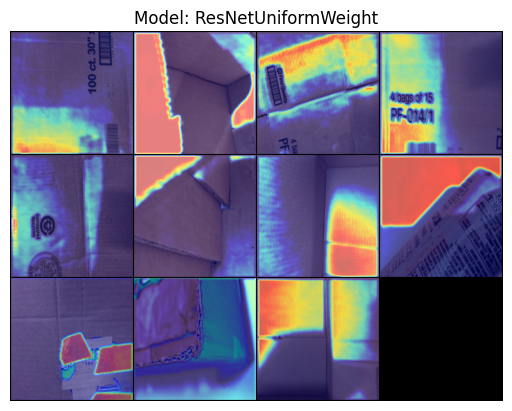

Class: glass


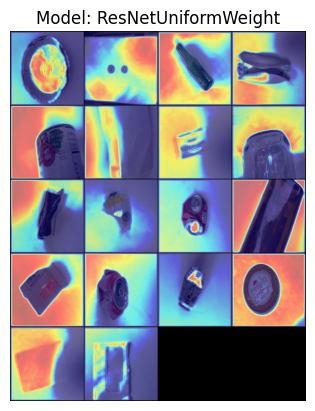

Class: metal


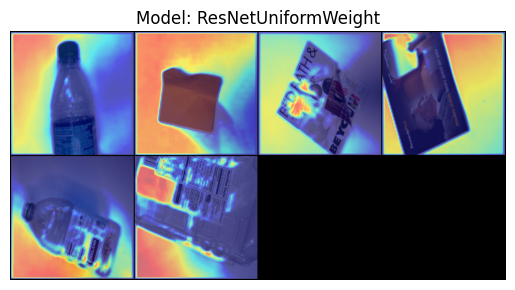

Class: paper


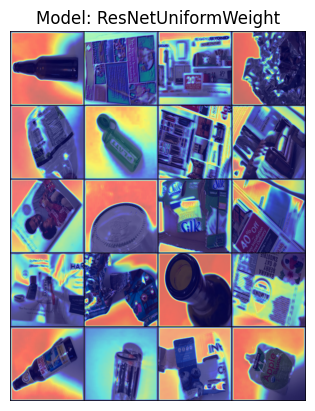

Class: plastic


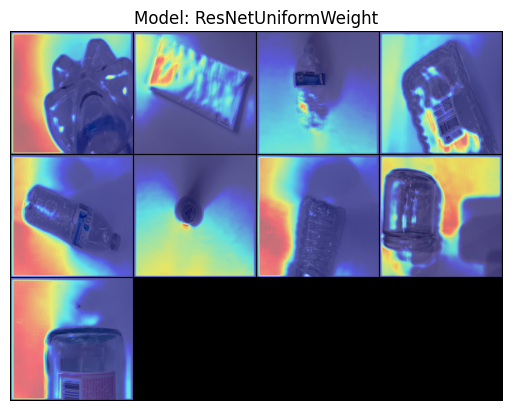

In [35]:
# Compute GradCAM for samples of each class
for label, images in class_images.items():
    print("Class: " + dataset.classes[label])
    display_grad_cam(model, [model.network.conv1], torch.from_numpy(np.array(images)))

YOUR ANSWER HERE

### Task 7: Experiments (optional)

Now, given all of this, it is up to you to analyse these algorithms, the outcomes, and determine the variables which contribute more; the Gemeente is relying on you for the future, so do your best to understand and advise based on this.

#### Assignment 6

Conduct experiments and write a short paragraph to recommend the best CNN, optimizer, and learning rate (of the ones used) for the Gemeente to carry forward in their development of a full pipeline AI garbage classifier. You can try [different network architecture](https://pytorch.org/vision/main/models.html#classification), number of epochs, learning rate, and weight initializations.

YOUR ANSWER HERE

### Task 7: Theory Questions

#### Assignment 7.1: Role of the Last Layer

We modified the ResNet architecture to replace only the last layer for our task. The rest of the neural net remains the same as we imported the network. What is the purpose of changing the last layer of the network?

YOUR ANSWER HERE

#### Assignment 7.2: Constant Weight Initialization

As you saw in Task 5, if we were not to randomize the model weights and instead initialize the weights to a constant value (or simply zero), we would encounter a famous problem of Deep Learning. Research online to discover what we call this issue, why it happens, and why randomly initializing the weights fixes this issue.

YOUR ANSWER HERE

#### Assignment 7.3: Weight Initialization Comparison

There are different types of weight initializations. You saw Zero, Gaussian Distributed, and Kaiming methods here. Research these methods, and try to explain briefly in your own words the strengths and weaknesses of each.

YOUR ANSWER HERE

#### Assignment 7.4: Network Complexity

You might think that a Deep Neural Network is always better. But as you saw in the tutorial, sometimes adding more layers to increase the complexity of neural networks may not really help. There is a name for the phenomenon of adding too much complexity, which may (or may not) make the performance worse. Find out what it is called and briefly describe why it happens and how to fix it if the architecture is to remain mostly the same.

YOUR ANSWER HERE

#### Assignment 7.5: Learning Rate

In Task 4, we used very low and high learning rates. This is a classic problem in Deep Learning. Identify what arises when we do this, and give your best resolutions to these issues (some of which we used).

YOUR ANSWER HERE

#### Assignment 7.6: Vanishing Gradient

Although we did not show you here, neural networks can suffer from Vanishing Gradient. An example of vanishing gradient can be found in [this notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial3/Activation_Functions.html#Visualizing-the-gradient-flow-after-initialization). Mathematically it is because in the back-propagation stage, the gradient of the loss function compared to the weights is too small ([here is more explaination](https://web.stanford.edu/class/cs224n/slides/cs224n-2023-lecture05-rnnlm.pdf)). They cannot update the weights enough to make meaningful changes. There are many ways to fix these issues. Try to list as many of them as possible, and using the above information and your own further research, try to convey why these fix the issue.

YOUR ANSWER HERE